# Running Semigrand Canonical Monte Carlo Sampling

In [1]:
import numpy as np
import json
from pymatgen.core.structure import Structure
from smol.io import load_work

### 0) Load the previous LNO CE with electrostatics

In [2]:
work = load_work('./data/basic_ce_ewald.mson')
expansion = work['ClusterExpansion']

### 1) Create a semigrand ensemble
The `MuSemigrandEnsemble` class is used to run semigrand canonical MC by fixing relative chemical potentials.

In SGC chemical potential differences are set as boundary conditions. Any one of the active species can be used as reference.

In [3]:
from smol.moca import MuSemiGrandEnsemble

# Create the ensemble
# This specifies the size of the MC simulation domain.
sc_matrix = np.array([[6, 1, 1],
                      [1, 2, 1],
                      [1, 1, 2]])

# relative chemical potentials are provided as a dict
chemical_potentials = {'Li+': 0, 'Vacancy': 0,
                       'Ni3+': 0, 'Ni4+': 0}

# this convenience method will take care of creating the appropriate
# processor for the given cluster expansion.
ensemble = MuSemiGrandEnsemble.from_cluster_expansion(expansion,
                                                      sc_matrix,
                                                      chemical_potentials=chemical_potentials)

print(f'The supercell size for the processor is {ensemble.processor.size} prims.\n')
print(f'The ensemble has a total of {ensemble.num_sites} sites.\n')
print(f'The active sublattices are:')
for sublattice in ensemble.sublattices:
    print(sublattice)

The supercell size for the processor is 16 prims.

The ensemble has a total of 64 sites.

The active sublattices are:
Sublattice
 Site space: {Species Ni3+: 0.5, Species Ni4+: 0.5}
 Number of sites: 16

Sublattice
 Site space: {Species Li+: 0.5, Vacancy vacA0+: 0.5}
 Number of sites: 16



### 2) Create an MC sampler
A `Sampler` will take care of running MC sampling runs for a given ensemble. The sampler allows many different options for MC sampling most importantly setting the MCMC algorithm and the type of MC steps taken. However the defaults are usually enough for almost all use cases.

In [5]:
from smol.moca import Sampler

# This will take care of setting the defaults
# for the supplied canonical ensemble
sampler = Sampler.from_ensemble(ensemble, temperature=500)

print(f"Sampling information: {sampler.samples.metadata}")

Sampling information: {'name': 'MuSemiGrandEnsemble', 'chemical-potentials': {'Li+': 0, 'vacA0+': 0, 'Ni3+': 0, 'Ni4+': 0}, 'kernel': 'Metropolis', 'step': 'flip', 'seed': 3294015828004676701}


### 3) Create an initial structure and get occupancies

In [6]:
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation

# Here we will just use the order disordered transformation from
# pymatgen to get an ordered version of a prim supercell.
# The structure will have the same composition set in the prim.
transformation = OrderDisorderedStructureTransformation()

supercell = expansion.cluster_subspace.structure.copy()
supercell.make_supercell(sc_matrix)

# this can take a bit of time....
test_struct = transformation.apply_transformation(supercell)
print(test_struct.composition)

Li+8 Ni3+8 Ni4+8 O2-32


In [7]:
# Obtain the initial occupancy string from the
# test structure created above.
init_occu = ensemble.processor.occupancy_from_structure(test_struct)

# The occupancy strings created by the processor
# are by default "encoded" by the indices of the species
# for each given site. You can always see the actual
# species in the occupancy string by decoding it.
print(f'The encoded occupancy is:\n{init_occu}')
print(f'The initial occupancy is:\n {ensemble.processor.decode_occupancy(init_occu)}')

The encoded occupancy is:
[0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
The initial occupancy is:
 [Species Li+, Vacancy vacA0+, Vacancy vacA0+, Species Li+, Species Li+, Species Li+, Vacancy vacA0+, Species Li+, Species Li+, Vacancy vacA0+, Species Li+, Vacancy vacA0+, Vacancy vacA0+, Vacancy vacA0+, Vacancy vacA0+, Species Li+, Species Ni3+, Species Ni3+, Species Ni4+, Species Ni4+, Species Ni4+, Species Ni4+, Species Ni3+, Species Ni4+, Species Ni3+, Species Ni3+, Species Ni4+, Species Ni3+, Species Ni3+, Species Ni3+, Species Ni4+, Species Ni4+, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species O2-, Species 

### 4) Sweeping chemical potentials

Using a semigrand ensemble, we can sweep through relative chemical potentials and get average energies at various compositions.

Here we will sweep only through the relative chemical potential of vacancies.

In [25]:
from smol.cofe.space import Vacancy
dmus = np.arange(4, 7, .25)
discard, thin_by = 50, 10
concentration_avgs = []
energy_avg = []
sampler.clear_samples()
# initialize sampler
chemical_potentials['Vacancy'] = dmus[0]
ensemble.chemical_potentials = chemical_potentials
sampler.run(10000, init_occu, thin_by=thin_by, progress=True)
energy_avg.append(sampler.samples.mean_energy(discard=discard))
# this gets the composition in all active sites
# excludes inactive sites (i.e. O2- in this case)
# to get the composition per sublattice only
# mean_sublattice_composition
concentration_avgs.append(sampler.samples.mean_composition(discard=discard))

# sweep through rest
for dmu in dmus[1:]:
    # update to get only averages of last samples
    # you can also clear samples and start fresh at each dmu
    discard_tot = discard + len(sampler.samples)
    chemical_potentials["Vacancy"] = dmu
    ensemble.chemical_potentials = chemical_potentials
    sampler.run(100000, thin_by=thin_by, progress=True)
    energy_avg.append(sampler.samples.mean_energy(discard=discard_tot))
    concentration_avgs.append(sampler.samples.mean_composition(discard=discard_tot))

Sampling 1 chain(s) at 500.00 K from a cell with 64 sites: 100%|██████████| 10000/10000 [00:01<00:00, 9229.11it/s]
Sampling 1 chain(s) at 500.00 K from a cell with 64 sites: 100%|██████████| 100000/100000 [00:10<00:00, 9504.88it/s]
Sampling 1 chain(s) at 500.00 K from a cell with 64 sites: 100%|██████████| 100000/100000 [00:10<00:00, 9575.92it/s]
Sampling 1 chain(s) at 500.00 K from a cell with 64 sites: 100%|██████████| 100000/100000 [00:10<00:00, 9570.72it/s]
Sampling 1 chain(s) at 500.00 K from a cell with 64 sites: 100%|██████████| 100000/100000 [00:10<00:00, 9391.45it/s]
Sampling 1 chain(s) at 500.00 K from a cell with 64 sites: 100%|██████████| 100000/100000 [00:10<00:00, 9185.83it/s]
Sampling 1 chain(s) at 500.00 K from a cell with 64 sites: 100%|██████████| 100000/100000 [00:10<00:00, 9547.06it/s]
Sampling 1 chain(s) at 500.00 K from a cell with 64 sites: 100%|██████████| 100000/100000 [00:10<00:00, 9520.06it/s]
Sampling 1 chain(s) at 500.00 K from a cell with 64 sites: 100%|██

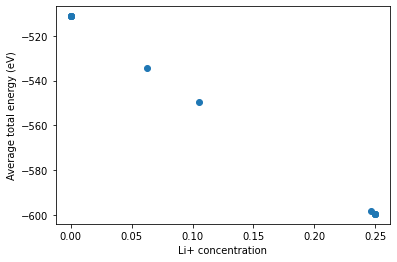

In [22]:
# Plot some results
import matplotlib.pyplot as plt
# We need to use this since species keys are pymatgen Specie objects
from smol.cofe.space import get_species

plt.plot([c[get_species("Li+")] for c in concentration_avgs],
          energy_avg, 'o')
plt.xlabel('Li+ concentration')
plt.ylabel('Average total energy (eV)')
plt.show()